### Predict Future Sales

We are provided with daily historical sales data. Our task is to analyse the data and highlight interesting features.

**File descriptions**

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv  - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

**Data fields**

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

import plotly.express as px
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected = True)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [2]:
ITEMS_CAT_PATH = '../input/competitive-data-science-predict-future-sales/item_categories.csv'
ITEMS_PATH = '../input/competitive-data-science-predict-future-sales/items.csv'
SALES_TRAIN_PATH = '../input/competitive-data-science-predict-future-sales/sales_train.csv'
SAMPLE_SUBMISSION_PATH = '../input/competitive-data-science-predict-future-sales/sample_submission.csv'
SHOPS_PATH = '../input/competitive-data-science-predict-future-sales/shops.csv'
TEST_PATH = '../input/competitive-data-science-predict-future-sales/test.csv'

In [3]:
items_cats = pd.read_csv(ITEMS_CAT_PATH)
items = pd.read_csv(ITEMS_PATH)
sales_train = pd.read_csv(SALES_TRAIN_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
shops = pd.read_csv(SHOPS_PATH)
test = pd.read_csv(TEST_PATH)


Lower the digit capacity of data types to optimise code work.

In [4]:
items_cats['item_category_id'] = pd.to_numeric(items_cats['item_category_id'], downcast='signed')
items[['item_id', 'item_category_id']] = items[['item_id', 'item_category_id']].apply(pd.to_numeric, downcast='signed')
sales_train[['date_block_num', 'shop_id', 'item_id']] = sales_train[['date_block_num', 'shop_id', 'item_id']].apply(pd.to_numeric, downcast='signed')
sales_train[['item_price', 'item_cnt_day']] = sales_train[['item_price', 'item_cnt_day']].apply(pd.to_numeric, downcast='float')
sample_submission['ID'] = pd.to_numeric(sample_submission['ID'], downcast='signed')
sample_submission['item_cnt_month'] = pd.to_numeric(sample_submission['item_cnt_month'], downcast='float')
shops['shop_id'] = pd.to_numeric(shops['shop_id'], downcast='signed')
test[['ID', 'shop_id', 'item_id']] = test[['ID', 'shop_id', 'item_id']].apply(pd.to_numeric, downcast='signed')

Merge several tables into one for easy reference.

In [5]:
sales_item = sales_train.merge(items, on='item_id', how='left')
sales_item_shops = sales_item.merge(shops, on='shop_id', how='left')
df = sales_item_shops.merge(items_cats, on='item_category_id', how='left')
df.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
2902959,17.10.2015,33,47,3443,1199.0,1.0,"Far Cry 4 [PC, русская версия]",30,"Сургут ТРЦ ""Сити Молл""",Игры PC - Стандартные издания
2450376,05.02.2015,25,15,3393,1699.0,1.0,"Fable Anniversary [Xbox 360, русские субтитры]",23,"Калуга ТРЦ ""XXI век""",Игры - XBOX 360
1648399,08.05.2014,16,6,21384,399.0,1.0,ХОББИТ: ПУСТОШЬ СМАУГА (2DVD+коллекционная открытка),40,"Воронеж (Плехановская, 13)",Кино - DVD
1921724,10.08.2014,19,5,14296,149.0,1.0,МАЛАВИТА,40,"Вологда ТРЦ ""Мармелад""",Кино - DVD
2404627,31.01.2015,24,54,12447,199.0,1.0,КЕЙТ И ЛЕО,40,"Химки ТЦ ""Мега""",Кино - DVD
2629584,31.05.2015,28,28,16538,249.0,1.0,ОКЕАН ЕЛЬЗИ Gloria (фирм.),55,"Москва ТЦ ""МЕГА Теплый Стан"" II",Музыка - CD локального производства
2553596,03.03.2015,26,26,12550,199.0,1.0,КЛАССИКА Маленькие шедевры великих композиторов 1,55,"Москва ТЦ ""Ареал"" (Беляево)",Музыка - CD локального производства
395755,02.04.2013,3,43,14303,399.0,1.0,МАЛЕНЬКИЙ ПРИНЦ: ПЛАНЕТА ВЕТРОВ/ПЛАНЕТА МУЗЫКИ,40,"СПб ТК ""Сенная""",Кино - DVD
2751356,25.07.2015,30,53,20953,999.0,1.0,Фляжка стальная WOT Снайпер (101609),69,"Уфа ТЦ ""Семья"" 2",Подарки - Сувениры
401144,28.04.2013,3,57,21440,399.0,2.0,ХРАНИТЕЛИ СНОВ,40,"Якутск Орджоникидзе, 56",Кино - DVD


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int8   
 2   shop_id             int8   
 3   item_id             int16  
 4   item_price          float32
 5   item_cnt_day        float32
 6   item_name           object 
 7   item_category_id    int8   
 8   shop_name           object 
 9   item_category_name  object 
dtypes: float32(2), int16(1), int8(3), object(4)
memory usage: 148.4+ MB


Lowercase the columns.

In [7]:
columns = ['item_name', 'shop_name', 'item_category_name']
for column in columns: df[column] = df[column].str.lower()

In [8]:
print('Count rows: ', df.shape[0])
print('Count columns: ', df.shape[1])

Count rows:  2935849
Count columns:  10


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.623413,1726.439819,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.612213,-22.0,1.0,1.0,1.0,2169.0
item_category_id,2935849.0,40.001383,17.100759,0.0,28.0,40.0,55.0,83.0


Here we can see anomalies in the data: a negative value for the price and quantity of goods sold per day.

In [10]:
print('Count of rows with abnormal price: {:.0f}'.format(len(df[df['item_price'] <= 0])))
print('Count of rows with abnormal quantity of goods sold per day: {:.0f}'.format(len(df[df['item_cnt_day'] < 0])))

Count of rows with abnormal price: 1
Count of rows with abnormal quantity of goods sold per day: 7356


Remove all rows with anomalies.

In [11]:
df = df[~(df['item_price'] <= 0) & ~(df['item_cnt_day'] < 0)]

In [12]:
df.describe(include = ['object']).T

,count,unique,top,freq
date,2928492,1034,28.12.2013,9415
item_name,2928492,21746,фирменный пакет майка 1с интерес белый (34*42) 45 мкм,31337
shop_name,2928492,60,"москва тц ""семеновский""",235185
item_category_name,2928492,84,кино - dvd,563938


In [13]:
print(f'Count duplicates: {df.duplicated().sum()}')
df = df.drop_duplicates()

Count duplicates: 6


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928486 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int8   
 2   shop_id             int8   
 3   item_id             int16  
 4   item_price          float32
 5   item_cnt_day        float32
 6   item_name           object 
 7   item_category_id    int8   
 8   shop_name           object 
 9   item_category_name  object 
dtypes: float32(2), int16(1), int8(3), object(4)
memory usage: 148.0+ MB


In [15]:
df['date'] = df['date'].astype('datetime64[Y]')

In [16]:
print('Min date:', df['date'].min().date())
print('Max date', df['date'].max().date())

Min date: 2013-01-01
Max date 2015-01-01


In [17]:
df_cnt_item = df.groupby('date_block_num').agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'date_block_num':'number_of_month', 'item_cnt_day':'item_cnt'})
fig = px.line(df_cnt_item, x="number_of_month", y="item_cnt")
fig.update_layout(
    title='The number of goods sold on a monthly basis',
    xaxis_title='Time',
    yaxis_title='Sales')
fig.show()

In the graph we see two sales peaks - in December 2013 (183. thousand) and December 2014 (169. thousand) . This is the time when people make the most purchases for New Year's Eve gifts.

In [18]:
df['sum_price'] = df.item_price * df.item_cnt_day

In [19]:
df_sales_sum = df.groupby('date_block_num').agg({'sum_price':'sum'}).reset_index().rename(columns={'date_block_num':'number_of_month', 'sum_price':'total_sales'})
fig = px.line(df_sales_sum, x='number_of_month', y='total_sales')
fig.update_layout(
    title='Total Sales',
    xaxis_title='Time',
    yaxis_title='Total prise')
fig.show()

In December 2014, there were fewer purchases than in December 2013, but they were more expensive. There is a clear seasonality in the data.

In [20]:
top_categories = df.groupby('item_category_id').agg({'item_id':'nunique'}).reset_index().rename(columns={'item_id':'count_items'}).sort_values(by='count_items', ascending=False).head(10)

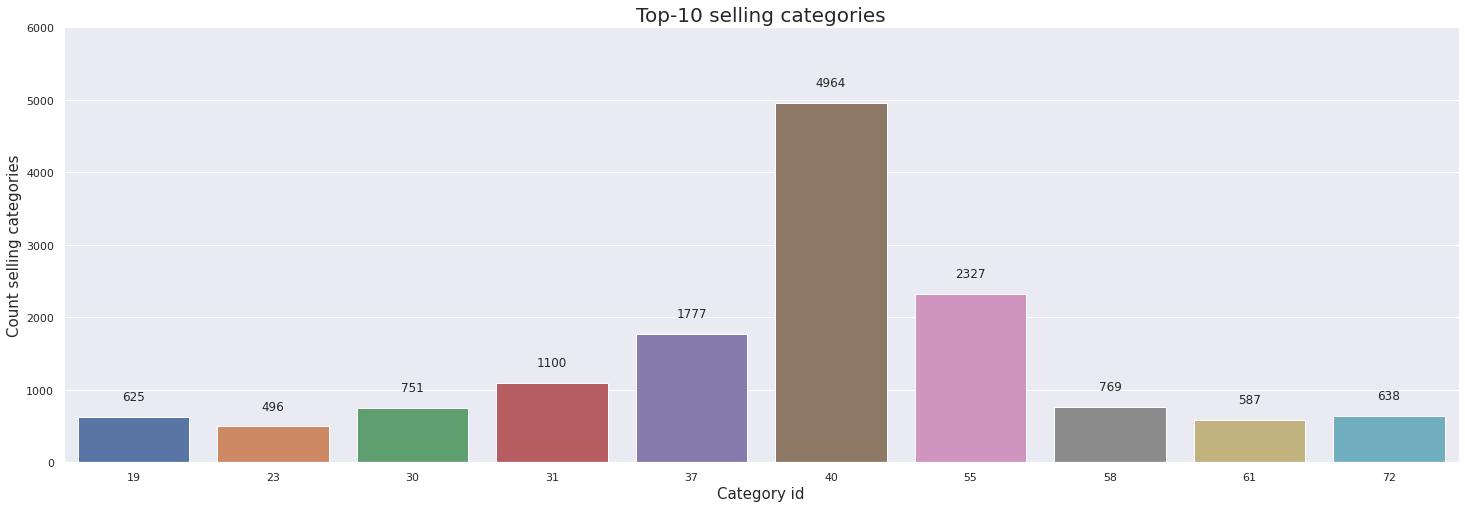

In [21]:
plt.figure(figsize=(25,8))
plt.title('Top-10 selling categories', size=20)
ax = sns.barplot(y=top_categories['count_items'], 
                 x=top_categories['item_category_id'])
for p in ax.patches:
        ax.annotate (str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Category id', size=15)
plt.ylabel('Count selling categories', size=15)
plt.ylim(None,6000)
plt.show()

Most goods were sold from category 40 - 4964 items during the whole period of the survey. In second place is category 55 with 2327 items and in third place the category 37 with 1777 items sold.

In [22]:
distribution_categories = df[df['item_category_id'].isin(top_categories['item_category_id'])]

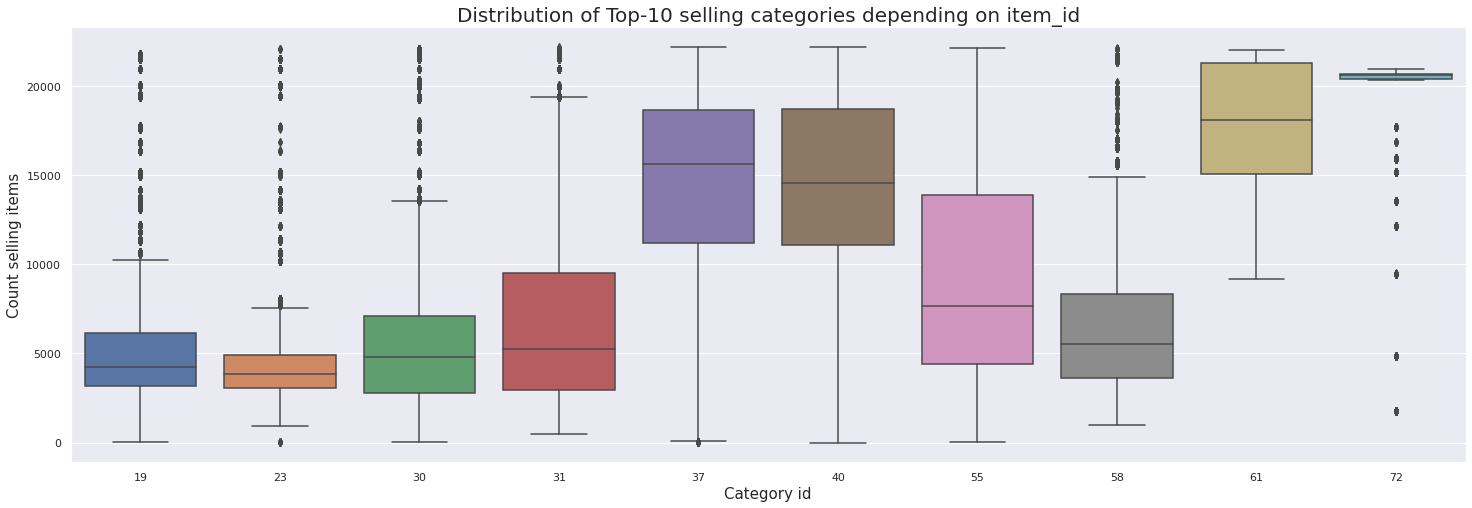

In [23]:
plt.figure(figsize=(25,8))
plt.title('Distribution of Top-10 selling categories depending on item_id', size=20)
ax = sns.boxplot(x="item_category_id", y="item_id", data=distribution_categories)
plt.xlabel('Category id', size=15)
plt.ylabel('Count selling items', size=15)
plt.show()

The greatest variation in values is observed for items in categories 37, 40 and 55. However, the categories 40 and 55 have no outliers. Goods in categories 19, 23 and 72 have the most abnormal values.

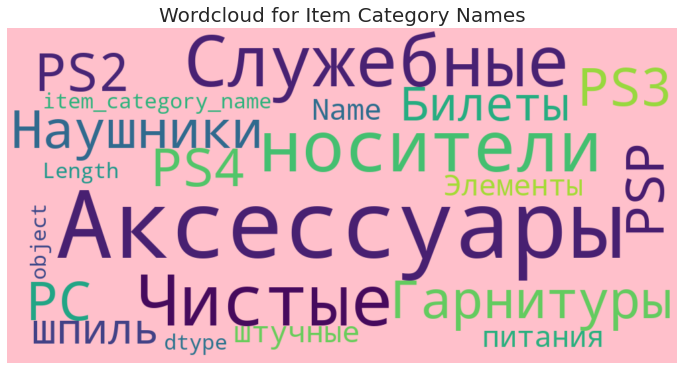

In [24]:
plt.rcParams['figure.figsize'] = (12, 8)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'pink',
                      max_words = 200, 
                      stopwords = stopwords,
                     width = 1000,
                     height = 500,
                     random_state = 42).generate(str(items_cats['item_category_name']))


plt.title('Wordcloud for Item Category Names', fontsize = 20)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.show()

In [25]:
items_per_shop = df.groupby('shop_name').agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_items'}).sort_values(by='total_cnt_items', ascending=False)

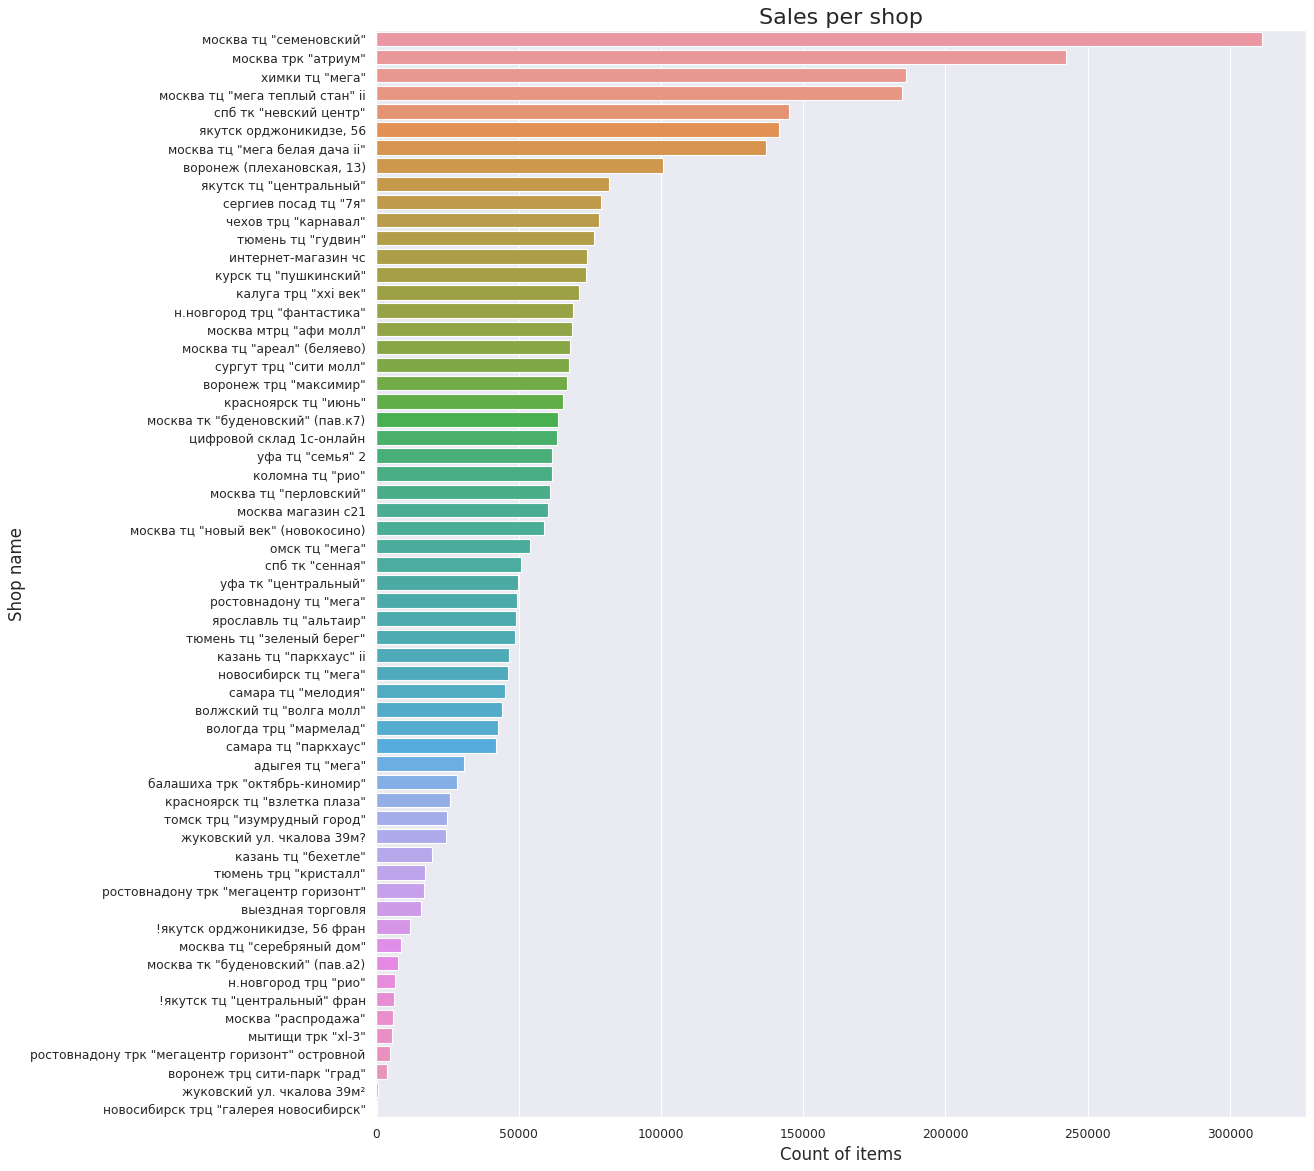

In [26]:
plt.figure(figsize=(15,18), dpi=80)
plt.title('Sales per shop', size=20)
ax = sns.barplot(x=items_per_shop['total_cnt_items'], y=items_per_shop['shop_name'])
plt.xlabel('Count of items', size=15)
plt.ylabel('Shop name', size=15)
plt.show()

Most goods were sold from the shop in Москва ТЦ "Семеновский" during the entire period.

In [27]:
cnt_items_shop_monthly = df.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_day':'sum'}).reset_index().sort_values(by='item_cnt_day', ascending=False)

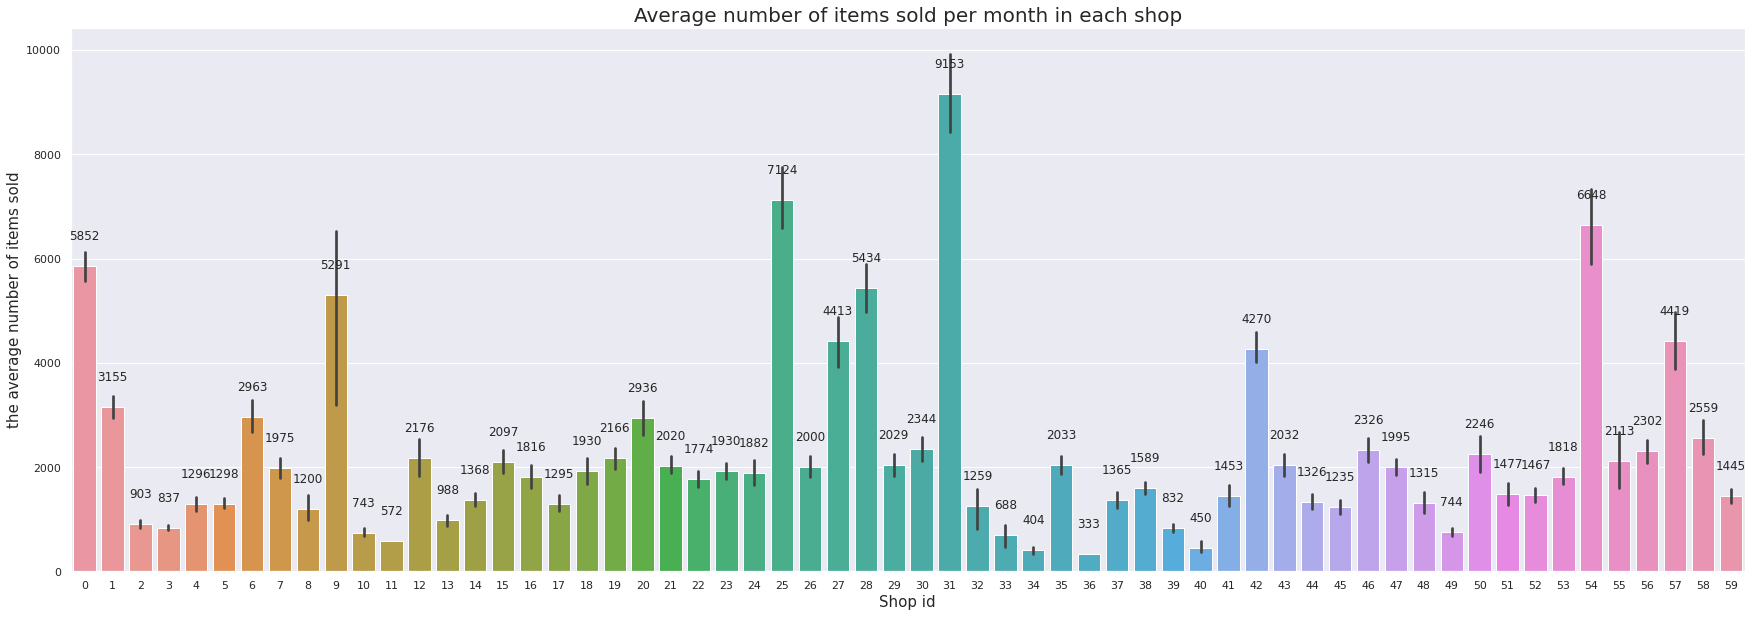

In [28]:
plt.figure(figsize=(30,10))
plt.title('Average number of items sold per month in each shop', size=20)
ax = sns.barplot(y=cnt_items_shop_monthly['item_cnt_day'], 
                 x=cnt_items_shop_monthly['shop_id'])
for p in ax.patches:
        ax.annotate (str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 30), textcoords='offset points')
plt.xlabel('Shop id', size=15)
plt.ylabel('the average number of items sold', size=15)
plt.show()

On average, shop 31 sold about 9,153 items monthly. Shop 25 sold 7,124 items and Shop 54 sold 6,648 items monthly. From the number of sales we can judge the size of the shop, so it is likely - they are the largest in our sample.

## Conclusions

* There are two sales peaks in the data - in December 2013 (183. thousand) and December 2014 (169. thousand) . This is the time when people make the most purchases for New Year's Eve gifts.
* In December 2014, there were fewer purchases than in December 2013, but they were more expensive. There is a clear seasonality in the data.
* Most goods were sold from category 40 - 4964 items during the whole period of the survey. In second place is category 55 with 2327 items and in third place the category 37 with 1777 items sold.
* The greatest variation in values is observed for items in categories 37, 40 and 55. However, the categories 40 and 55 have no outliers. Goods in categories 19, 23 and 72 have the most abnormal values.
* Most goods were sold from the shop in Москва ТЦ "Семеновский" during the entire period.
* On average, shop 31 sold about 9,153 items monthly. Shop 25 sold 7,124 items and Shop 54 sold 6,648 items monthly. From the number of sales we can judge the size of the shop, so it is likely - they are the largest in our sample.